In [1]:
import numpy as np;
import networkx as nx;
import pandas as pd;
import matplotlib.pyplot as plt;
import math;

## Reading the network data

The yeast network was already used previously...

In [2]:
yeast_net = nx.read_edgelist('yeastinter_st.txt',data = False);       # we ignore the 3rd column in the file

The other network is the social network between FIFA leaders based on commitee co-memberships.

Although we have learned that sparse networks should be better stored as link lists, this network is publicly available in a matrix format...

First we just peek into the data using pandas:

In [3]:
pd.read_csv('2015_FIFA_1M.csv',sep = ',',index_col=0)

,ABDULLAH Prince H.R.H,ABEGA Prosper,ABO RIDA Hany,ACHE Eduardo,ACKERMANN Nair,ACOSTA Francisco,ADAMS Mark,ADOUM Djibrine,AGHAZADA Sayed,AHMAD Ahmad,...,WILKINSON Rhian,WILLIAMSON Stephen,WINDTNER Leo,WONUHALI Linda,WOODSON Rochell,YAHYA Ahmed,ZAMBRANO Jose,ZAW Zaw,ZERGUINI Yacine,ZHANG Jian
ABDULLAH Prince H.R.H,4,0,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ABEGA Prosper,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABO RIDA Hany,2,0,4,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
ACHE Eduardo,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACKERMANN Nair,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YAHYA Ahmed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ZAMBRANO Jose,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
ZAW Zaw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ZERGUINI Yacine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


And now we actually read the matrix into a pandas dataframe, which can then converted into a network by networkx.

In [4]:
FIFA_df = pd.read_csv('2015_FIFA_1M.csv',sep = ',',index_col=0);
FIFA_net = nx.convert_matrix.from_pandas_adjacency(FIFA_df);

Let's look at the basic network properties of the two networks:

In [5]:
print('yeast net N =',yeast_net.number_of_nodes(),', L =',yeast_net.number_of_edges());
print('yeast net max. degree = ',max([yeast_net.degree(node) for node in yeast_net.nodes]));
print();
print('FIFA net N =',FIFA_net.number_of_nodes(),', L =',FIFA_net.number_of_edges());
print('yeast net max. degree = ',max([FIFA_net.degree(node) for node in FIFA_net.nodes]));

yeast net N = 688 , L = 1078
yeast net max. degree =  71

FIFA net N = 450 , L = 5472
yeast net max. degree =  117


## Preparing the E and e matrices

A straight forward approach to study the degree correlations in a network is offered by the **E** matrix, in which rows and collumns correspond to the possible node degrees in the network from 1 to $k_{\rm max}$, and $E_{k_1,k_2}$ is simply the number of connected node pairs where the degree of the first node is $k_1$ and the degree of the second node is $k_2$. (The diagonal elements $E_{kk}$ correspond to twice the number of links between nodes of the same degree $k$ in order to treet all links and degree pairings in a fair manner). Since every link in the network contributes to **E** twice, the sum of all entries is $\sum_{i,j}E_{k_i,k_j}=2L$, where $L$ is the total number of links. 

The **e** matrix is simply the **E** matrix, where we divide all entries by $2L$.  This way the sum of the elements in **e** is equal to 1.

We prepare a function calculating the **E** and **e** matrices:

In [6]:
def Prepare_Ee_matrices(network):
    max_degree = max([network.degree(node) for node in network.nodes]);   # the maximum degree in the network.
    E_matr = np.zeros(shape = (max_degree+1,max_degree+1),dtype = int);   # a matrix full of zeros.
    for node1 in network.nodes:
        k1 = network.degree(node1);
        for node2 in network.neighbors(node1):
            k2 = network.degree(node2);                                   # note that no 'extra' care is needed
            E_matr[k1,k2] += 1;                                           # for the diagonal elements.
            
    e_matr = np.zeros(shape = (max_degree+1,max_degree+1),dtype = float);
    for k1 in range(0,max_degree+1):
        for k2 in range(0,max_degree+1):
            e_matr[k1,k2] = E_matr[k1,k2]/(2.0*network.number_of_edges());
    return E_matr,e_matr;

First let's try it out on the yeast network.

In [7]:
yeast_E_matr,yeast_e_matr = Prepare_Ee_matrices(yeast_net);

Let's have a look at basic properties of the **E** matrix:

In [8]:
print('yeast E matrix shape:',yeast_E_matr.shape);
print('yeast E matr.:\n',yeast_E_matr);
print('yeast E matr. sum:',sum(sum(yeast_E_matr)));

yeast E matrix shape: (72, 72)
yeast E matr.:
 [[ 0  0  0 ...  0  0  0]
 [ 0 12 12 ...  0  0 23]
 [ 0 12  8 ...  0  0 35]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 23 35 ...  0  0  0]]
yeast E matr. sum: 2156


Same for the **e** matrix:

In [9]:
print('yeast e matrix shape:',yeast_e_matr.shape);
print('yeast e matr.:\n',yeast_e_matr);
print('yeast e matr. sum:',sum(sum(yeast_e_matr)));

yeast e matrix shape: (72, 72)
yeast e matr.:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00556586 0.00556586 ... 0.         0.         0.0106679 ]
 [0.         0.00556586 0.00371058 ... 0.         0.         0.01623377]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0106679  0.01623377 ... 0.         0.         0.        ]]
yeast e matr. sum: 1.0000000000000002


Seems to work fine, let's prepare the matrices for the FIFA network as well.

In [10]:
FIFA_E_matr,FIFA_e_matr = Prepare_Ee_matrices(FIFA_net);

## Heatmap from the E and e matrices

Luckily, it is very easy to make a 2d heatmap of the matrices using pyplot.

<Figure size 432x288 with 0 Axes>

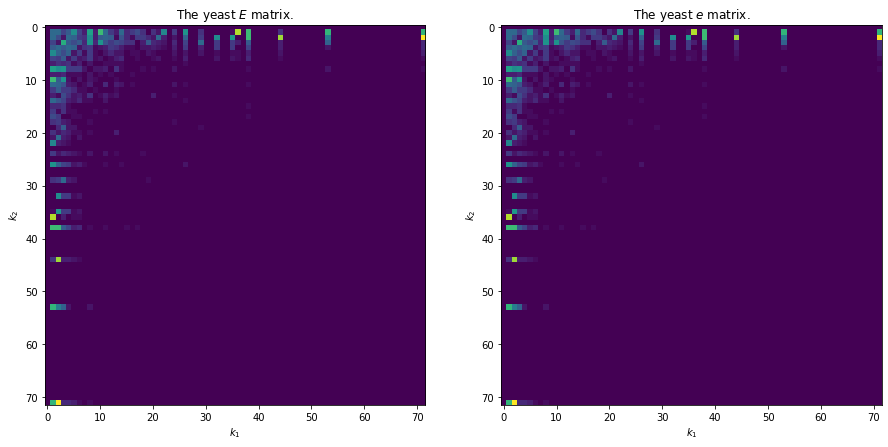

In [11]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_E_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $E$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(yeast_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ matrix.')
#plt.colorbar();
plt.show();

Actually, it is much more interesting to compare the **e** matrices for the yeast and the FIFA network:

<Figure size 432x288 with 0 Axes>

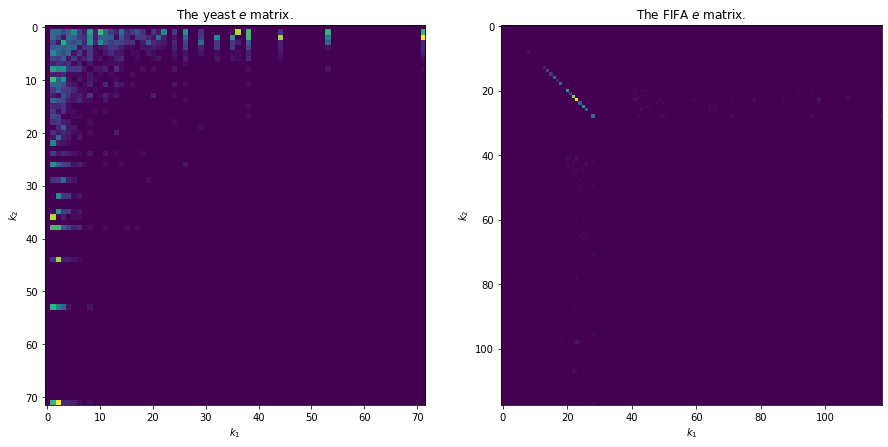

In [12]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(FIFA_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The FIFA $e$ matrix.')
#plt.colorbar();
plt.show();

## Calculating the neutral e matrix

The **e** matrix corresponding to a neutral network with the same size and degree distribution can be obtained by first calculating the row (or column) sums $q_i = \sum_j e_{ij}$ and then preparing a matrix where the entries are simply the products of the corresponding $q$ values, i.e., $$e^{\rm (neut)}_{ij} =q_i\cdot q_j$$

In [13]:
def Calc_neutral_matr(orig_e_matr):
    _q_list = [sum(orig_e_matr[i]) for i in range(orig_e_matr.shape[1])];
    _neut_matr = np.zeros(orig_e_matr.shape);
    for i in range(0,len(_q_list)):
        for j in range(0,len(_q_list)):
            _neut_matr[i,j] = _q_list[i]*_q_list[j];
    return _neut_matr;

In [14]:
yeast_neut_e = Calc_neutral_matr(yeast_e_matr);
FIFA_neut_e = Calc_neutral_matr(FIFA_e_matr);

<Figure size 432x288 with 0 Axes>

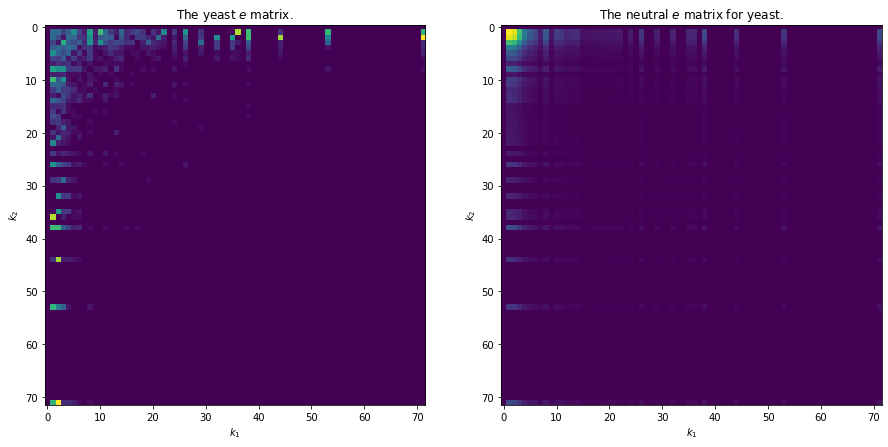

In [15]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(yeast_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The yeast $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(yeast_neut_e,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The neutral $e$ matrix for yeast.')
#plt.colorbar();
plt.show();

<Figure size 432x288 with 0 Axes>

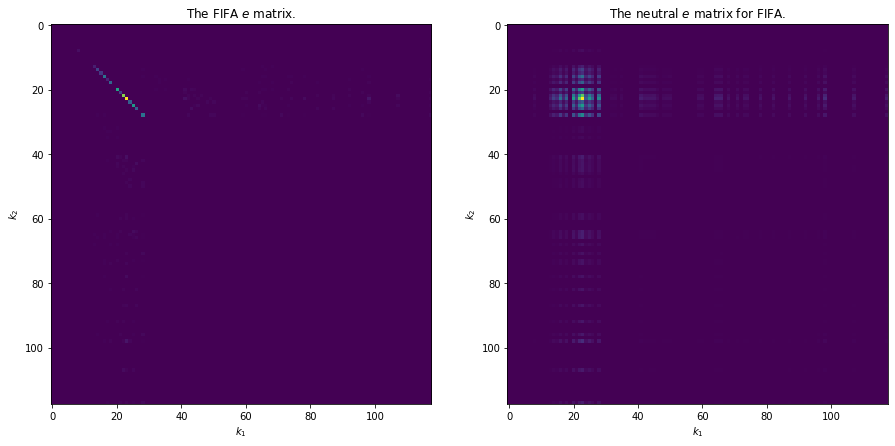

In [16]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(FIFA_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The FIFA $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(FIFA_neut_e,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The neutral $e$ matrix for FIFA.')
#plt.colorbar();
plt.show();

## Logarithmic values in the e matrix

In case of the FIFA network, the range of the matrix elements is over several orders of magnitude, thus, the heatmap actually hides a lot of information. A simple way to overcome this is to take the logarithm of the non-zero elements, and replace the 0 elements with a uniform low value.

In [17]:
print('max. elem. in FIFA e-matr.:',max([max(FIFA_e_matr[i]) for i in range(0,FIFA_e_matr.shape[0])]));
print('possible min. non-zero elem. in FIFA e-matr.:',0.5/FIFA_net.number_of_edges());

max. elem. in FIFA e-matr.: 0.1095577485380117
possible min. non-zero elem. in FIFA e-matr.: 9.137426900584795e-05


In [18]:
def Log_e_matr(orig_e_matr):
    _log_e_matr = np.ndarray(orig_e_matr.shape,dtype=float);
    _min_val = 1.0;
    for i in range(orig_e_matr.shape[0]):
        for j in range(orig_e_matr.shape[1]):
            if (orig_e_matr[i,j] > 0) and (orig_e_matr[i,j] < _min_val):
                _min_val = orig_e_matr[i,j];
    _min_val *= 0.01;
    for i in range(orig_e_matr.shape[0]):
        for j in range(orig_e_matr.shape[1]):
            if orig_e_matr[i,j] == 0:
                _log_e_matr[i,j] = math.log(_min_val);
            else:
                _log_e_matr[i,j] = math.log(orig_e_matr[i,j]);
    return _log_e_matr;

In [19]:
log_FIFA_e_matr = Log_e_matr(FIFA_e_matr);
log_FIFA_neut_e = Log_e_matr(FIFA_neut_e);

<Figure size 432x288 with 0 Axes>

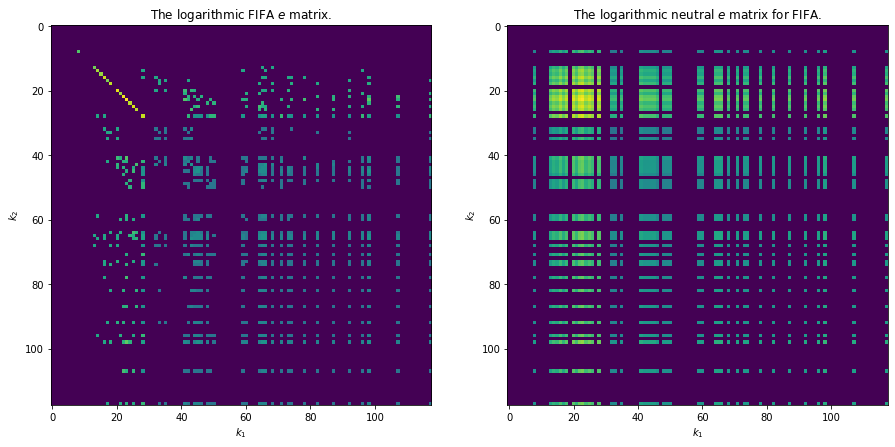

In [20]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(log_FIFA_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The logarithmic FIFA $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(log_FIFA_neut_e,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The logarithmic neutral $e$ matrix for FIFA.')
#plt.colorbar();
plt.show();

In [21]:
log_yeast_e_matr = Log_e_matr(yeast_e_matr);
log_yeast_neut_e = Log_e_matr(yeast_neut_e);

<Figure size 432x288 with 0 Axes>

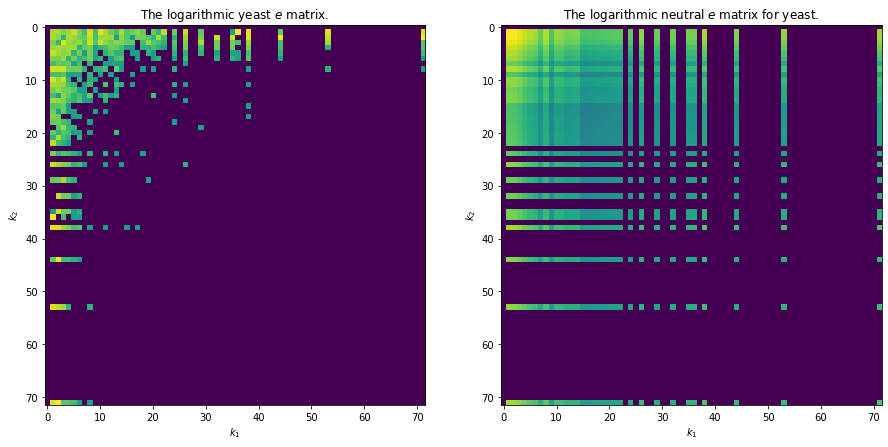

In [22]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,10))
plt.subplot(121);
plt.imshow(log_yeast_e_matr,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The logarithmic yeast $e$ matrix.')
#plt.colorbar();

plt.subplot(122);
plt.imshow(log_yeast_neut_e,cmap = 'viridis');
plt.xlabel('$k_1$');
plt.ylabel('$k_2$');
plt.title('The logarithmic neutral $e$ matrix for yeast.')
#plt.colorbar();
plt.show();

## Average Nearest Neighbours Degree

A simpler description of the degree correlations can be given using the neighbours average degree as a function of the node degree, which is often denoted by $k_{nn}(k)$. Luckily there is a built in function in networkx to calculate the neighbours average degree, so based on that we can construct $k_{nn}(k)$.

First let's just demonstrate the built in function for calculating the neighbours average degrees:

In [23]:
FIFA_av_neigh_k = nx.algorithms.average_neighbor_degree(FIFA_net);
print(FIFA_av_neigh_k);

{'ABDULLAH Prince H.R.H': 38.13793103448276, 'ABEGA Prosper': 22.571428571428573, 'ABO RIDA Hany': 36.972972972972975, 'ACHE Eduardo': 31.52173913043478, 'ACKERMANN Nair': 25.8125, 'ACOSTA Francisco': 20.05, 'ADAMS Mark': 24.555555555555557, 'ADOUM Djibrine': 30.26086956521739, 'AGHAZADA Sayed': 30.26086956521739, 'AHMAD Ahmad': 14.0, 'AHMED Essam El-Din': 31.52173913043478, 'AHMED Hosny Abdelrahman': 29.764705882352942, 'AHO Lui': 26.45, 'AHOUANVOEBLA Sedogbo': 30.26086956521739, 'AKHTER Mahfuza': 20.23076923076923, 'AL BUSAIDI Khalid Hamed Hamood': 28.3125, 'AL DELAWAR Abdulrahman': 36.17857142857143, 'AL HARBI Ahmed Eid': 36.22727272727273, 'AL KHALIFA Shk. Ali Bin Khalifa': 32.52173913043478, 'AL KHALIFA Shk. Salman Bin Ebrahim': 39.49315068493151, 'AL KHELAIFI Nasser': 29.0, 'AL MAADHEED Mohammed Ghanim Al Ali': 29.764705882352942, 'AL MEDLEJ Hafez': 17.214285714285715, 'AL NOWAISER Mohammed': 33.0, 'AL RAJOUB Jibril': 24.863636363636363, 'AL SABAH Sheikh Ahmad Al Fahad': 48.47916

We need to collect these average values 'degree-vise', and then again, take the average for any given degree value.

In [24]:
def Calc_knn(network):
    node_neighs_av_k = nx.algorithms.average_neighbor_degree(network);
  
    k_neighs_av_k = {};             # this is going to be a dict where keys are degrees, and values are 
                                    # the neighbours average degrees.
    for node in node_neighs_av_k:
        k = network.degree(node);                             # the degree of the node
        if k in k_neighs_av_k:                                # checking whether this k has already appeared
            k_neighs_av_k[k].append(node_neighs_av_k[node]);  # appending the neigh. average to the list
        else:
            k_neighs_av_k[k] = [node_neighs_av_k[node]];       
            
    for k in k_neighs_av_k:
        av_av_k = np.mean(k_neighs_av_k[k]);     # we use numpy to calculate the average of the collected list
                                                 # of neighbours average degrees.
            
        k_neighs_av_k[k] = av_av_k;              # we replace the list by its average.
        
    sort_k_nn = sorted(k_neighs_av_k.items(), key = lambda x:x[0]); # sorting the result according to the degree
    return sort_k_nn;

In [25]:
knn_yeast = Calc_knn(yeast_net);
print(knn_yeast);

[(1, 23.79090909090909), (2, 28.02547770700637), (3, 17.658008658008654), (4, 15.978571428571428), (5, 11.663157894736843), (6, 12.805555555555552), (7, 5.714285714285714), (8, 6.90625), (9, 5.0), (10, 2.6), (11, 6.418181818181819), (12, 3.4166666666666665), (13, 7.41025641025641), (14, 3.8095238095238098), (15, 4.6), (16, 3.25), (17, 4.0588235294117645), (18, 3.6666666666666665), (19, 4.473684210526316), (20, 4.55), (21, 2.619047619047619), (22, 1.4545454545454546), (24, 4.958333333333333), (26, 3.7884615384615383), (29, 3.2413793103448274), (32, 2.90625), (35, 2.8), (36, 1.4166666666666667), (38, 2.894736842105263), (44, 2.3181818181818183), (53, 2.0754716981132075), (71, 2.112676056338028)]


In [26]:
knn_FIFA = Calc_knn(FIFA_net);

Let us plot the obtained $k_nn(k)$ functions.

<Figure size 432x288 with 0 Axes>

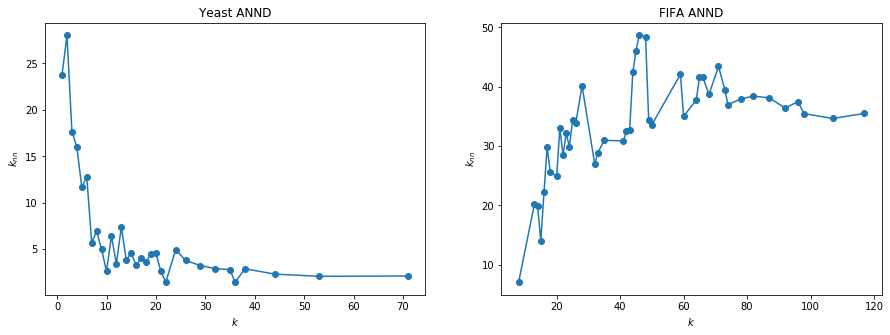

In [27]:
plt.clf();
f, axs = plt.subplots(2,2,figsize=(15,5))
plt.subplot(121);
k_list = [knn_yeast[i][0] for i in range(0,len(knn_yeast))];
knn_list = [knn_yeast[i][1] for i in range(0,len(knn_yeast))];
plt.plot(k_list,knn_list,'-o')
plt.xlabel('$k$');
plt.ylabel('$k_{nn}$');
plt.title('Yeast ANND')

plt.subplot(122);
k_list = [knn_FIFA[i][0] for i in range(0,len(knn_FIFA))];
knn_list = [knn_FIFA[i][1] for i in range(0,len(knn_FIFA))];
plt.plot(k_list,knn_list,'-o')
plt.xlabel('$k$');
plt.ylabel('$k_{nn}$');
plt.title('FIFA ANND')
plt.show()

## Assortativity coefficient

To reduce the number of parameters even further, we can actually summarize the degree correlation properties into a single number, corresponding to the Pearson correlation of the joint distribution of the degrees based on the $e$ matrix. Luckily networkx has a built in function for calculating this.

In [28]:
yeast_r_coeff = nx.algorithms.assortativity.degree_assortativity_coefficient(yeast_net);
FIFA_r_coeff = nx.algorithms.assortativity.degree_assortativity_coefficient(FIFA_net);

print('yeast r: ',yeast_r_coeff,' FIFA r: ',FIFA_r_coeff);

yeast r:  -0.3995192375289176  FIFA r:  0.14258691820805858
